In [1]:
# import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score
from torch import nn
from torchvision import transforms as T
import torchvision.models as models

from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1. Load dataloaders

In [4]:
train_ds = torch.load("data/train_dataset.pt")
eval_ds = torch.load("data/eval_dataset.pt")

In [3]:
def get_majority_clf(ds):
    """Returns accuracy of the majority classifier"""
    # Get the labels from the dataset
    labels = ds.labels
    
    # Calculate the majority class label and its count
    majority_class = np.argmax(np.bincount(labels))
    majority_class_count = np.sum(labels == majority_class)
    
    # Calculate the accuracy of the majority classifier
    accuracy = majority_class_count / len(labels)
    
    return majority_class, accuracy

In [7]:
print(get_majority_clf(eval_ds))
print(len(set(train_ds.labels)))

(1028, 0.0037114979911995406)
910


In [24]:
len(train_ds.data), len(train_ds.labels), len(eval_ds.data), len(eval_ds.labels)

(120809, 120809, 52270, 52270)

In [25]:

mapping = {}
rev_mapping = {}
for i, label in enumerate(set(train_ds.labels)):
    mapping[i] = label
    rev_mapping[label] = i
    
train_mapped_labels = [rev_mapping[label] for label in train_ds.labels]
eval_mapped_labels = [rev_mapping[label] for label in eval_ds.labels]

print(len(train_mapped_labels))

train_ds.labels = train_mapped_labels
eval_ds.labels = eval_mapped_labels

BATCH_SIZE = 8

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_dl = DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=True)

120809


In [26]:
min(mapping.keys()), min(rev_mapping.keys()), max(mapping.keys()), max(rev_mapping.keys())

(0, 0, 909, 1309)

In [27]:
len(train_ds.labels), len(train_ds.data)

(120809, 120809)

In [28]:
# Check if shapes are ok
en1, en2 = train_ds[0], train_ds[5]

en1[0].shape, en2[0].shape

(torch.Size([3, 64, 64]), torch.Size([3, 64, 64]))

#### Set the train loop

In [29]:
loss_history = []
accuracy_history = []

def train(model, criterion, optimizer, train_loader, valid_loader, epochs, save_path="models/model"):
    best_val_loss = float('inf')  # Initialize with infinity
    
    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)    
    
    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        val_loss = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        loss_history.append(loss.item())    
        
        scheduler.step(val_loss)
        
        # Inspect the learning rate changes
        for param_group in optimizer.param_groups:
            print(f"Learning rate: {param_group['lr']}")
        
        # Validation loop
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
                # Get accuracy
                _, pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
        
        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(valid_loader)
        
        val_acc = 100 * (correct / total)
        
        accuracy_history.append(val_acc)
        
        print(f"Validation accuracy: {val_acc:0.3f}%")
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
        
        # Save the model if validation loss is improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{save_path}_{epoch+1}")
            print("Model saved with validation loss:", best_val_loss)


### 2. Get model and set it up

In [30]:
import os

model = models.resnet50(pretrained=True)
model = model.to(device)

n_features = model.fc.in_features
n_classes = train_ds.get_n_classes()

model.fc = nn.Linear(n_features, n_classes)

if os.path.exists("models/resnet50.pt"):
    model.load_state_dict(torch.load("models/resnet50.pt"))

model = model.to(device)

c:\Users\sebas\miniconda3\envs\trust-me\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sebas\miniconda3\envs\trust-me\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 3. Train the model

In [31]:
LR = 1e-4

n_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [32]:
train(model, criterion, optimizer, train_dl, eval_dl, n_epochs, "models/resnet50.pt")

Learning rate: 0.0001
Validation accuracy: 78.447%
Epoch 1/20, Train Loss: 0.3337, Valid Loss: 1.3726
Model saved with validation loss: 1.3726332339279461
Learning rate: 0.0001
Validation accuracy: 80.356%
Epoch 2/20, Train Loss: 0.3132, Valid Loss: 1.2197
Model saved with validation loss: 1.2197469316138427
Learning rate: 0.0001
Validation accuracy: 80.218%
Epoch 3/20, Train Loss: 0.2740, Valid Loss: 1.2451
Learning rate: 0.0001
Validation accuracy: 81.236%
Epoch 4/20, Train Loss: 0.2377, Valid Loss: 1.1879
Model saved with validation loss: 1.1878979153999873
Learning rate: 0.0001
Validation accuracy: 80.515%
Epoch 5/20, Train Loss: 0.2113, Valid Loss: 1.2291
Learning rate: 0.0001
Validation accuracy: 80.771%
Epoch 6/20, Train Loss: 0.1875, Valid Loss: 1.1682
Model saved with validation loss: 1.1682027566566084
Learning rate: 1e-05
Validation accuracy: 81.795%
Epoch 7/20, Train Loss: 0.1725, Valid Loss: 1.1489
Model saved with validation loss: 1.1488653904561392
Learning rate: 1e-05
V

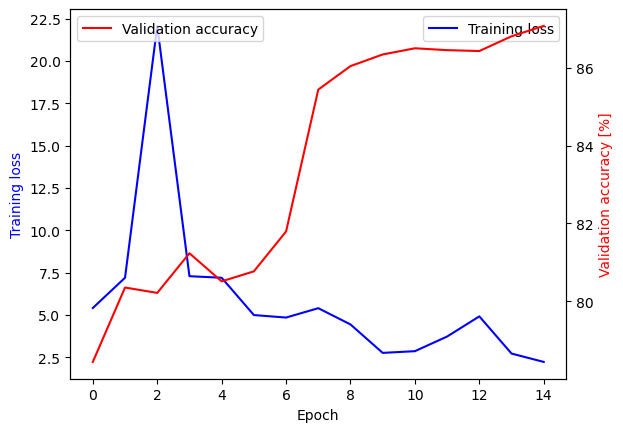

In [33]:
import matplotlib.pyplot as plt

epoch_cutoff = 15

# Create a figure and primary y-axis
fig, ax1 = plt.subplots()

# Plot data on the primary y-axis
ax1.plot(loss_history[:epoch_cutoff], color='blue', label='Training loss')
ax1.set_ylabel('Training loss', color='blue')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot data on the secondary y-axis
ax2.plot(accuracy_history[:epoch_cutoff], color='red', label='Validation accuracy')
ax2.set_ylabel('Validation accuracy [%]', color='red')

# Add legend
ax1.legend(loc='best')
ax2.legend(loc='best')
ax1.set_xlabel("Epoch")
# Show plot
plt.show()